In [1]:
''' A script to generate a synthetic dataset replacing the original one.'''
#  !pip install pyvinecopulib synthia numpy

import pandas as pd
import seaborn as sns
import numpy as np
# import pyvinecopulib as pv
import synthia as syn
import warnings, pickle, sys
warnings.filterwarnings('ignore')

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:

# fname = sys.argv[1]

fname = 'c211p01.csv'
coupled = True

data  = pd.read_csv(fname)
dtypes = data.dtypes
numeric = data.columns[dtypes.apply(pd.api.types.is_numeric_dtype)]

subset = data.loc[:,numeric].replace(np.nan, 0)

subset


,Area name,Age 4 and under,Age 5 to 9,Age 10 to 14,Age 15 to 19,Age 20 to 24,Age 25 to 29,Age 30 to 34,Age 35 to 39,Age 40 to 44,Age 45 to 49,Age 50 to 54,Age 55 to 59,Age 60 to 64,Age 65 to 69,Age 70 to 74,Age 75 to 79,Age 80 to 84,Age 85 to 89,Age 90 and over
0,0.0,5700,5700,6300,6000,5600,5000,5400,6500,7300,5200,6500,5600,5800,4200,3900,3300,2200,1300,500
1,0.0,9400,8500,10100,11700,9800,8300,8100,9000,9900,8300,9200,7900,7500,5700,5200,4300,3100,1700,800
2,0.0,7600,7800,8800,8100,7600,7000,7700,9500,10400,7100,9400,8500,9500,7800,6600,5000,3700,2100,1000
3,0.0,12300,11500,12800,12700,12600,11400,12000,14100,14600,11000,13400,11600,11600,8700,7400,6100,4300,2400,1100
4,0.0,6600,6200,6400,6100,6600,6400,6800,7600,8000,6100,7300,6300,6700,5200,4500,3500,2600,1700,800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
338,0.0,4600,5700,5700,4300,3800,4100,5100,6800,7600,4800,6500,6300,6900,5600,4400,3700,2700,1700,900
339,0.0,9500,9400,9900,10000,9400,9200,8900,10800,10700,8600,9400,7800,8500,6800,5800,4700,3400,2100,1000
340,0.0,6600,7900,8000,6500,5900,5800,7000,9000,10000,6600,9200,9400,10900,9100,7100,5700,4200,2700,1400
341,0.0,3600,3500,3800,4000,4200,3400,3400,4300,4400,3100,4100,3500,3800,2900,2400,1900,1400,800,400


In [3]:
#  Generate a synthetic dataset - presume that values are independant
generator = syn.CopulaDataGenerator()

if coupled:
    parameterizer = syn.QuantileParameterizer(n_quantiles=100)
    generator.fit(subset, copula=syn.GaussianCopula(), parameterize_by=parameterizer)
else:
    generator.fit(subset, copula=syn.IndependenceCopula())

print(f'Storage size: {len(pickle.dumps(generator))} bytes')
# samples = generator.generate(n_samples=len(subset))
samples = generator.generate(n_samples=len(subset), uniformization_ratio=0, stretch_factor=1)



synthetic = pd.DataFrame(samples, columns = subset.columns, index = subset.index)

NameError: name 'coupled' is not defined

In [ ]:
subset.describe()

In [ ]:
synthetic.describe()

In [ ]:
update = data.loc[:]
update.loc[:,numeric]= synthetic.loc[:,numeric]
update.astype(dtypes,inplace=True)

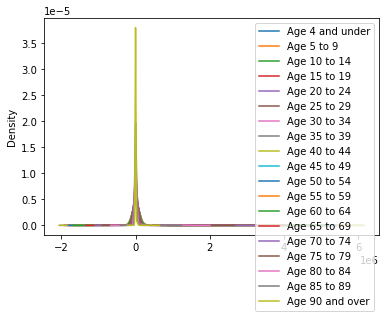

In [ ]:
data.plot(kind='box')
data.iloc[:,2:].plot(kind='kde')


In [ ]:
update.plot(kind='box')
update.iloc[:,2:].plot(kind='kde')

In [ ]:
Estimates the characteristics of a set of multi-feature samples and generates synthetic samples with the same or modified characteristics, based on copulas.

The input can be a numpy array or xarray DataArray of shape (sample, feature), or an xarray Dataset where all variables have shapes like (sample[, …]). For Datasets, all extra dimensions except the first are treated as features.

The output is in the same form as the input.

Algorithm:

Fitting phase

(Gaussian copula) The multivariate correlation between features is estimated and stored as correlation matrix with shape (feature,feature). Matrix values are between -1 and 1 inclusive.

(Vine copula) The pyvinecopulib package is used to fit a vine copula that captures the multivariate correlation between features. See that package for further details.

(Optional) Some or all features of the input data are parameterized. If a feature is not parameterized, then the original data is used during generation. Parameterization may impact the quality of the synthetic samples. It can be useful for storing/re-distributing a data generator for later use without requiring the original data.

Per-feature summary statistics (min, max, median) of the input data are computed. These statistics are only used if the synthetic samples should be generated with modified characteristics (uniformization, stretching).

In [ ]:
Generation phase

Generate new samples from the fitted copula model (Gaussian or Vine).

Transform copula samples to the feature scale by the quantile transform.

(Optional) Apply modifications (uniformization, stretching) if asked for.